In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

import infomap

In [2]:

tv_path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/yeast/tvshow_edges.csv'


In [3]:

def read_undirected_graph_csv(file_path, skip_lines):
    G = nx.Graph()  # Initialize an empty undirected graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split(',')
              # Only consider lines with exactly two node identifiers
            u = parts[0]
            v = parts[1]
            G.add_edge(u, v)
    
    return G


In [5]:
G = read_undirected_graph_csv(tv_path, 0)

G.remove_edges_from(nx.selfloop_edges(G))


In [6]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores


def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [8]:
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)


In [9]:
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)



In [27]:
#betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)


#sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
sorted_closeness = sorted(closeness.items(), key=lambda item: item[1], reverse=True)


In [10]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


  Infomap v2.7.1 starts at 2024-05-19 16:43:22
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 3892 nodes and 17239 links...
  -> One-level codelength: 11.053311

Trial 1/1 starting at 2024-05-19 16:43:22
Two-level compression: 43% 1.6% 0.156838656% 0.0374097748% 0.00647954412% 
Partitioned to codelength 0.775632033 + 5.42301894 = 6.198650974 in 248 modules.
Super-level compression: 1.20148543% to codelength 6.124175086 in 20 top modules.

Recursive sub-structure compression: 30.5567189% 2.35559034% 0.00298553701% 0% 

In [11]:

# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id

In [13]:
def calculate_mu(partition):

    # 初始化社区内和社区外的边数
    intra_community_edges = 0
    inter_community_edges = 0

    # 计算社区内和社区外的边数
    for edge in G.edges():
        if partition[edge[0]] == partition[edge[1]]:
            intra_community_edges += 1
        else:
            inter_community_edges += 1

    # 计算混合参数 μ
    mu = inter_community_edges / (intra_community_edges + inter_community_edges)
    
    return mu

In [14]:
calculate_mu(partition_infomap)

0.023261210046986485

In [15]:
def community_aware_ranking_ours_v6(G, partition, incommunity, total_budget):
    # Step 1: Organize nodes into communities
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    # Step 2: Compute community scores
    community_scores = {}
    for comm_id, nodes in communities.items():
        internal_edges = G.subgraph(nodes).size()  # Number of edges within the community
        size = len(nodes)
        external_connections = {}  # Initialize as a dictionary

        for node in nodes:
            for neighbor in G.neighbors(node):
                if partition[neighbor] != comm_id:
                    if partition[neighbor] not in external_connections:
                        external_connections[partition[neighbor]] = 0
                    external_connections[partition[neighbor]] += 1

        # Score calculation based on internal structure and external community sizes
        score = size * internal_edges
        for ext_comm_id, conn_count in external_connections.items():
            score += conn_count * len(communities[ext_comm_id])

        community_scores[comm_id] = score

    print(community_scores)
    # Step 3: Rank communities by score
    ranked_communities = sorted(community_scores.items(), key=lambda item: item[1], reverse=True)
    ranked_community_ids = [comm_id for comm_id, _ in ranked_communities]

    # Step 4: Allocate budget cyclically, selecting nodes from ranked communities
    selected_nodes = set()
    remaining_budget = total_budget
    # Sort nodes within each community by their importance
    for comm_id in ranked_community_ids:
        communities[comm_id].sort(key=lambda x: incommunity[x], reverse=True)

    # Cycle through communities until budget is exhausted
    index = 0
    while remaining_budget > 0:
        comm_id = ranked_community_ids[index % len(ranked_community_ids)]
        if communities[comm_id]:
            selected_nodes.add(communities[comm_id].pop(0))
            remaining_budget -= 1
        index += 1

    return selected_nodes


In [16]:
def calculate_cbc(G, community_dict):
    # 初始化每个节点的社区中心性为0
    cbc = {node: 0 for node in G.nodes()}
    
    # 计算每个社区的大小
    community_sizes = {}
    for node, community in community_dict.items():
        if community not in community_sizes:
            community_sizes[community] = 0
        community_sizes[community] += 1

    # 计算每个节点的社区中心性
    for node in G.nodes():
        community_links = {}
        for neighbor in G.neighbors(node):
            community = community_dict[neighbor]
            if community not in community_links:
                community_links[community] = 0
            community_links[community] += 1
        
        for community, links in community_links.items():
            cbc[node] += links / community_sizes[community]

    return cbc

In [17]:

budget = 100


ranked_nodes_V6 = community_aware_ranking_ours_v6(G, partition_infomap,degree_centrality, budget)


{1: 18311436, 2: 924776, 3: 271394, 4: 214730, 5: 99929, 6: 63077, 7: 123584, 8: 59468, 9: 46995, 10: 37987, 11: 64468, 12: 27946, 13: 54316, 14: 18904, 15: 16018, 16: 17061, 17: 3943, 18: 4829, 19: 1162, 20: 4038}


In [18]:
community_baseline = calculate_cbc(G, partition_infomap)
sorted_community_baseline = sorted(community_baseline.items(), key=lambda item: item[1], reverse=True)


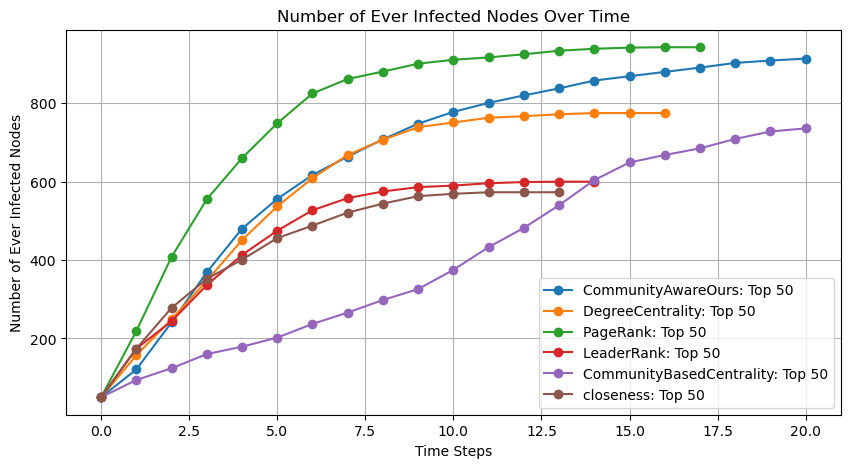

In [67]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    #avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
   # print(avg_in_degree)
    #recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 0.7, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_V6],
    "DegreeCentrality": sorted_centrality,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "CommunityBasedCentrality": sorted_community_baseline,
    "closeness": sorted_closeness
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=50, infection_prob=0.08,steps=20)

In [40]:


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

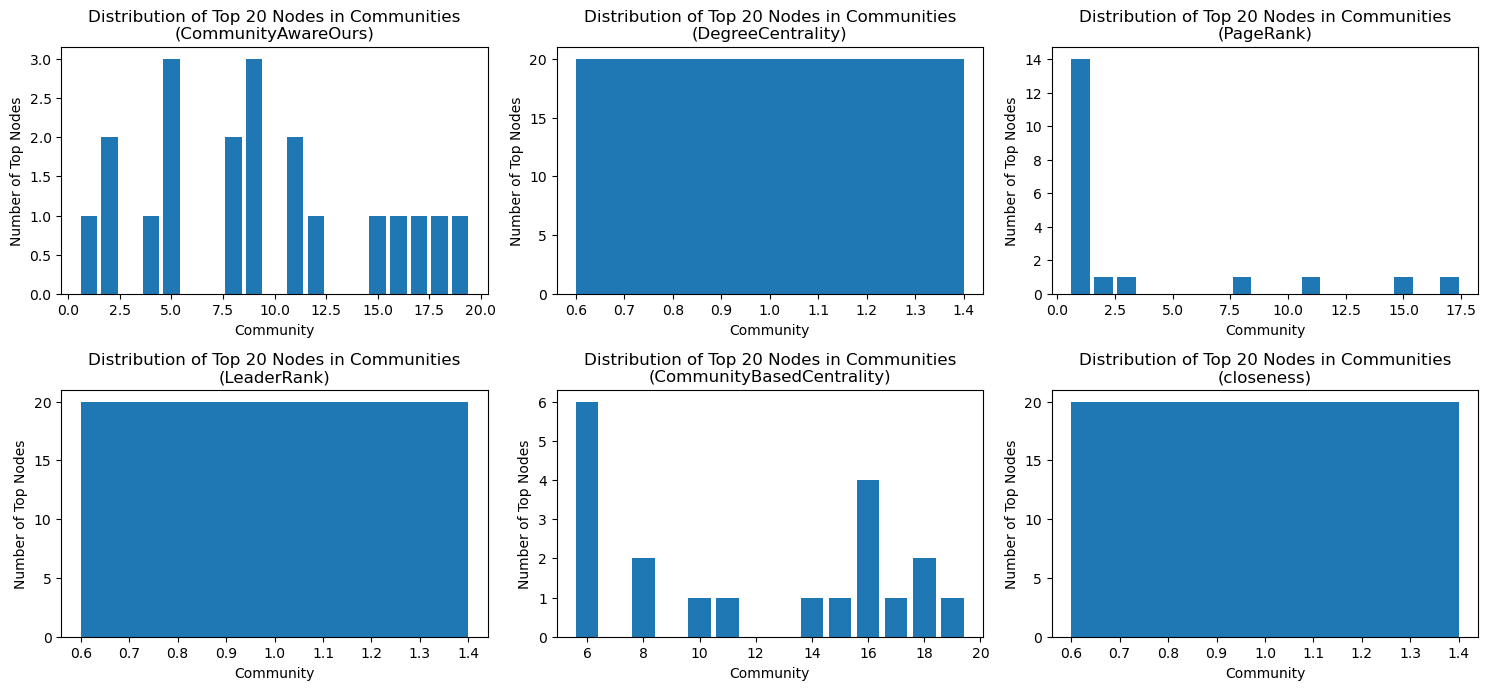

In [41]:

top = 20

community_counts = count_top_nodes_in_communities(G, sorted_maps, top, partition_infomap)
plot_top_nodes_distribution(community_counts, top)

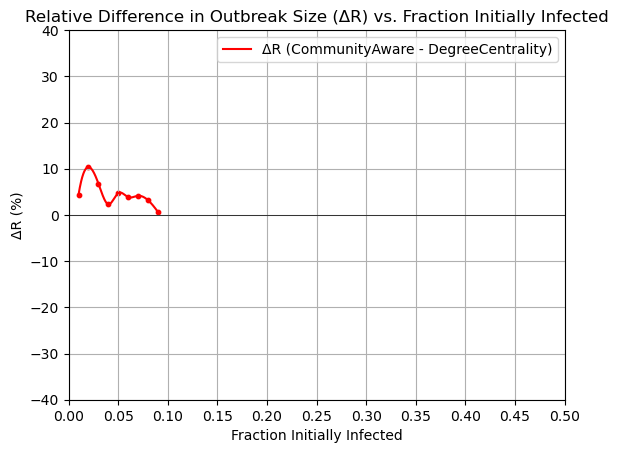

In [65]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# SIR Simulation function
def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'
    
    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]

    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                neighbors = G.predecessors(node) if G.is_directed() else G.neighbors(node)
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))
        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts

# Function to run simulation and plot results
def plot_sir_simulation(G, sorted_maps, infection_prob=0.05, recovery_prob=0.05, steps=100):
    results = {name: [] for name in sorted_maps.keys()}
    
    initial_infected_ratios = [i/100 for i in range(1, 10)] 

    for ratio in initial_infected_ratios:
        for name, sorted_map in sorted_maps.items():
            top_count = int(ratio * G.number_of_nodes())
            top_nodes = [node for node, _ in sorted_map[:top_count]]
            _, _, infected_counts = SIR_simulation(G, top_nodes, infection_prob, recovery_prob, steps)
            results[name].append(infected_counts[-1] / G.number_of_nodes() * 100)
    
    # Calculate ΔR for each initial infected ratio
    delta_R = [results["CommunityAware"][i] - results["DegreeCentrality"][i] for i in range(len(initial_infected_ratios))]

    # Interpolate to smooth the line
    interp_func = interp1d(initial_infected_ratios, delta_R, kind='cubic')
    smooth_x = np.linspace(min(initial_infected_ratios), max(initial_infected_ratios), 500)
    smooth_y = interp_func(smooth_x)

    # Plot ΔR
    plt.plot(smooth_x, smooth_y, color='red', label="ΔR (CommunityAware - DegreeCentrality)")
    plt.scatter(initial_infected_ratios, delta_R, color='red', s=10)  # Plot original points for reference

    plt.title('Relative Difference in Outbreak Size (ΔR) vs. Fraction Initially Infected')
    plt.xlabel('Fraction Initially Infected')
    plt.ylabel('ΔR (%)')
    plt.axhline(0, color='black', linewidth=0.5)  # Add a horizontal line at y=0
    plt.ylim(-40, 40)  # Set y-axis limits to ensure 0 is centered
    plt.xticks([i/20 for i in range(11)])  # Set x-axis ticks at 0.05 intervals
    plt.grid(True)
    plt.legend()
    plt.show()


sorted_maps = {
    "CommunityAware": [(node, degree_centrality[node]) for node in ranked_nodes_V6],
    #"CommunityAwareV7": [(node, degree_centrality[node]) for node in ranked_nodes_V7],
    "DegreeCentrality": sorted_centrality,
   # "PageRank": sorted_pagerank,
   # "LeaderRank": sorted_leaderRank,
    #"CommunityBasedCentrality": sorted_community_baseline,
    #"closeness": sorted_closeness
}

# Run simulation and plot
plot_sir_simulation(G, sorted_maps, infection_prob=0.08, recovery_prob=0.7, steps=15)


In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10):
    # 检查 selected_nodes 的数量不小于 top_n
   

    # 选择 top_n 个节点进行突出显示
    # 确保 selected_nodes 列表中只有节点标识符
    top_selected_nodes = [node[0] for node in selected_nodes[:top_n]]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=top_selected_nodes, node_color='red', node_size=100)
    # 可选：添加节点的标签
    # nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in top_selected_nodes})

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 使用示例
# 假设 G 是你的图对象，selected_nodes 是已按度中心性排序的节点列表（列表元素为(node, centrality)格式）
# visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10)


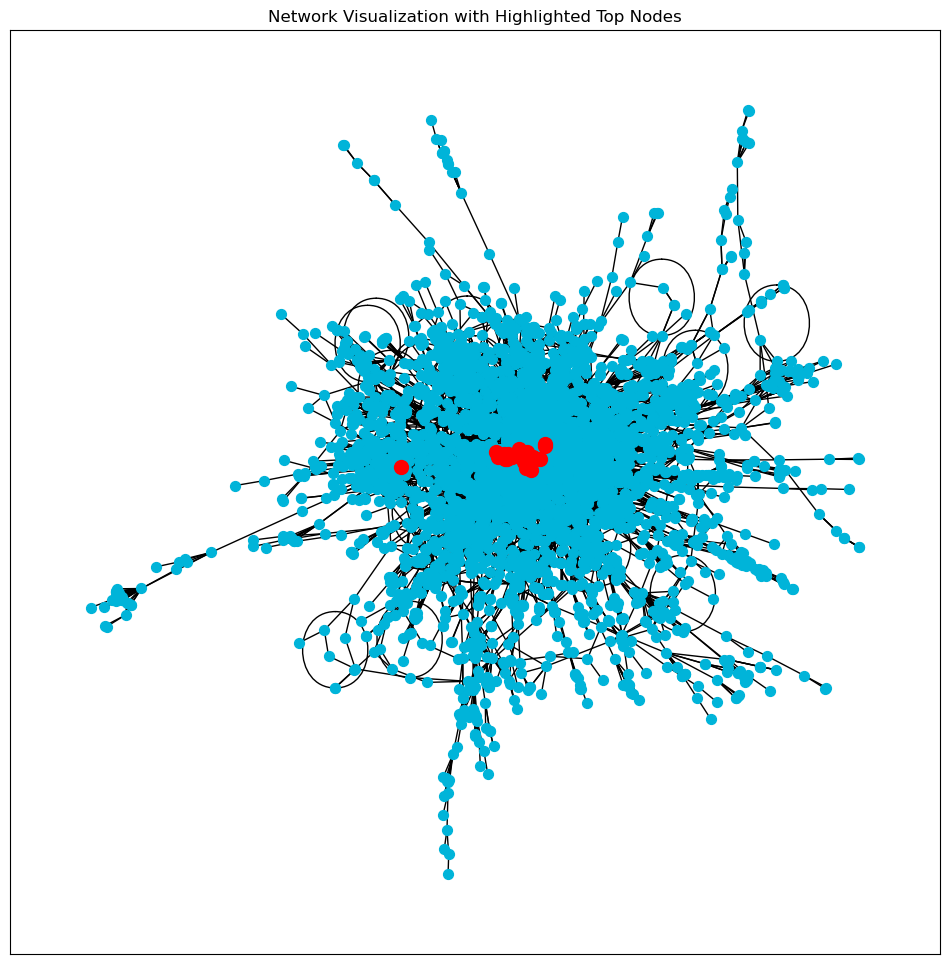

In [56]:
visualize_selected_nodes_with_highlight(G, sorted_centrality, top_n=50)

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_to_Selected(G, selected_nodes, top):
    # 计算网络中节点的数量
    network_size = len(G.nodes())

    # 设置低位数比例为网络大小的 15%
    low_fraction = top
    

    # 确保 selected_nodes 是列表，以便进行索引和切片操作
    selected_nodes = list(selected_nodes)[:low_fraction] if isinstance(selected_nodes, set) else selected_nodes[:low_fraction]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='red', node_size=100)
    # 添加标签（可选）
    # nx.draw_networkx_labels(G, pos)

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 假设 G 是你的图对象，partition 是社区划分，selected_nodes 是选出的节点列表（已排序）
# visualize_selected_nodes_with_highlight(G, partition, selected_nodes)


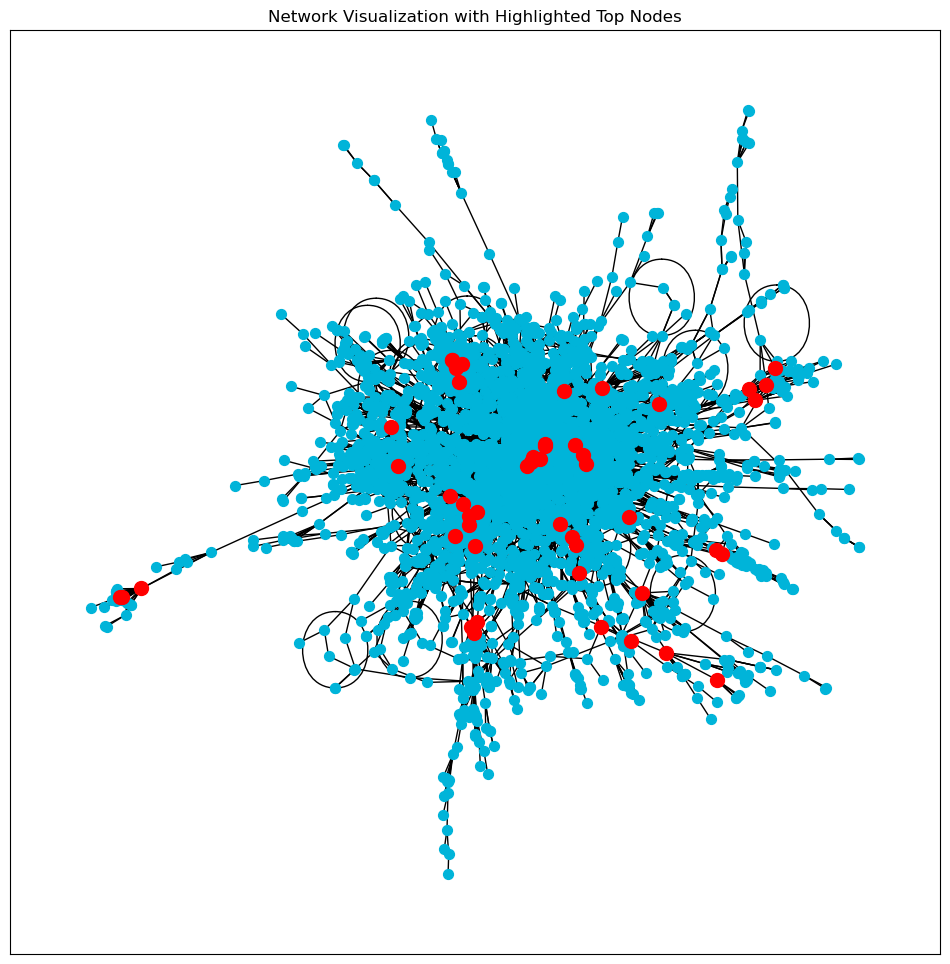

In [58]:
visualize_selected_nodes_to_Selected(G, ranked_nodes_ours,50)